### 概述
#### torch.utils.data工具包
包括4个类
- Dataset: 是一个抽象类，其他数据集需要继承这个类，并且重写_getitem_和__len__
- DataLoader: 定义一个新的迭代器，实现批量batch读取，打乱数据shuffle以及并行加速
- random_split: 把数据集随机拆分为给定长度的非重叠的新数据集
- \*sampler: 多种采样函数

#### torchvision
是独立于pytorch的一个视觉处理工具包，包括4个类
- datasets: 提供常用的数据集，设计上都是继承自torch.utils.data.Dataset，有MNIST,CIFAR10/100,ImageNet,COCO等
- models: 提供深度学习中各种经典的网络结构以及训练好的模型(需要参数pretrained=True)，包括AlexNet,VGG,ResNet,Inception等
- transforms: 常用的数据预处理操作，主要包括对Tensor以及PIL Image对象的操作
- utils: 含有两个函数
    1. make_grid：可以将多张图片拼接在一个网格中
    2. save_img：将Tensor保存为图片

### utils.data
##### Dataset
是抽象类，需要实现__len__，用来获得数据的大小(size)，和__getitem__，用来根据指定索引获得数据和标签，一次只能获取一个数据，所以需要通过DataLoader定义一个新的迭代器，实现批量batch读取

In [6]:
# 导入需要的module
import torch
from torch.utils import data
import numpy as np

In [11]:
# 定义获取数据集的类
class TestDataset(data.Dataset):
    def __init__(self):
        self.Data = np.asarray([[1,2],[3,4],[2,1],[3,4],[5,6]]) # 一些2维向量表示的数据集
        self.Label = np.asarray([0,1,0,1,2]) # 表示label
        
    def __getitem__(self,index):
        # 把numpy 转换成tensor
        txt = torch.from_numpy(self.Data[index])
        label = torch.tensor(self.Label[index])
        
        return txt,label
    
    def __len__(self):
        return len(self.Data)

In [12]:
# 获取数据集中的数据
Test = TestDataset()

In [19]:
Test[0]

(tensor([1, 2]), tensor(0))

数据是tuple返回，每次返回一个样本，Dataset只负责数据的抽取，调用一次__getitem__只返回一个样本

如果需要batch操作，还要同时shuffle和并行加速，需要使用DataLoader

### DataLoader的格式为
```python
data.DataLoader(
    dataset, #需要加载的数据集
    batch_size=1, #批大小
    shuffle=False, 
    sampler=None, #样本抽样
    batch_sampler=None, 
    num_workers=0, #使用多进程加载的进程数，0代表不实用多进程
    collate_fn=, #如何将多个样本数据拼接成一个batch，一般默认
    pin_memory=False, #是否将数据保存在pin memory区域，这个区域的数据转到GPU会快一些
    drop_last=False, #如果dataset划分为batch不整除，是否丢弃多余部分
    timeout=0,
    worker_init_fn=None
)
```

In [21]:
test_loader = data.DataLoader(dataset=Test,batch_size=2,shuffle=True,num_workers=2)
for i, train_data in enumerate(test_loader):
    print('i:',i)
    data,label = train_data
    print('data:',data)
    print('label:',label)

i: 0
data: tensor([[2, 1],
        [3, 4]])
label: tensor([0, 1])
i: 1
data: tensor([[5, 6],
        [3, 4]])
label: tensor([2, 1])
i: 2
data: tensor([[1, 2]])
label: tensor([0])


我们可以像使用迭代器一样使用它，但是它不是真正的迭代器，可以使用iter转换成迭代器
```python
data_iter = iter(test_loader)
imgs,labels = next(data_iter)
```
**一般使用data.Dataset处理同一个目录下的数据，如果数据在不同目录下，代表不同类别，就需要torchvision来处理，torchvision可以自动获取标签，提供了很多数据预处理、数据增强等函数**

### torchvision
#### transforms
提供了对PIL Image对象和Tensor对象的操作
1. 对PIL Image的操作
- Scale/Resize：调整尺寸，长宽比保持不变
- CenterCrop、RandomCrop、RandomSizedCrop：裁剪图片，前两个在crop的时候需要提供size，而最后一个是random size的crop
- Pad：填充
- ToTensor：把一个取值范围是[0,255]的PIL.Image转换成Tensor；numpy中的ndarray的shape是(H,W,C)，转换成[C,H,W]的tensor，转换成torch.FloatTensor，取值范围是[0.0,1.0]
- RandomHorizontalFlip：随机水平翻转
- RandomVerticalFlip
- ColorJitter：修改亮度、饱和度、对比度
2. 对Tensor的操作
- Normalize：标准化
- ToPILImage

如果要对数据集进行多个操作，可以使用Compose将操作像管道一样拼接起来，类似于nn.Sequential
```python
transforms.Compose([
    transforms.CenterCrop(10), # 提供一个参数，切出来就是正方形
    transforms.RandomCrop(20,padding=0),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))
])
```

#### ImageFolder
如果文件根据标签处于不同文件夹下，可以使用torchvision.datasets.ImageFolder构造出dataset
```python
loader = datasets.ImageFolder(path)
loader = data.Dataloader(dataset)
```
ImageFolder会将目录中的文件夹名自动转化成序列，当DataLoader载入的时候，标签就是整数序列

In [4]:
from torchvision import transforms, utils
from torchvision import datasets
from torch.utils import data
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
my_trans = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

tensor([1, 1, 1, 1, 1, 0, 1, 1])


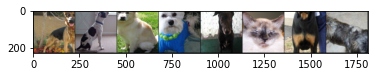

In [20]:
train_data = datasets.ImageFolder('./data/catanddog',transform=my_trans)
train_loader = data.DataLoader(train_data,batch_size=8,shuffle=True)

for i_batch, img in enumerate(train_loader):
    if i_batch == 0:
        print(img[1])
        fig = plt.figure()
        grid = utils.make_grid(img[0])
        plt.imshow(grid.numpy().transpose((1,2,0)))
        plt.show()
        utils.save_image(grid,'test01.jpg')
        
    break

In [16]:
# 看一下DataLoader的结构
for a,b in train_loader:
    print(a.shape)
    print(utils.make_grid(a).shape)
    print(b)
    break
    
# for img in train_loader:
#     print(img)
#     break

torch.Size([8, 3, 224, 224])
torch.Size([3, 228, 1810])
tensor([0, 1, 0, 0, 0, 0, 1, 0])


In [22]:
grid.shape

torch.Size([3, 228, 1810])

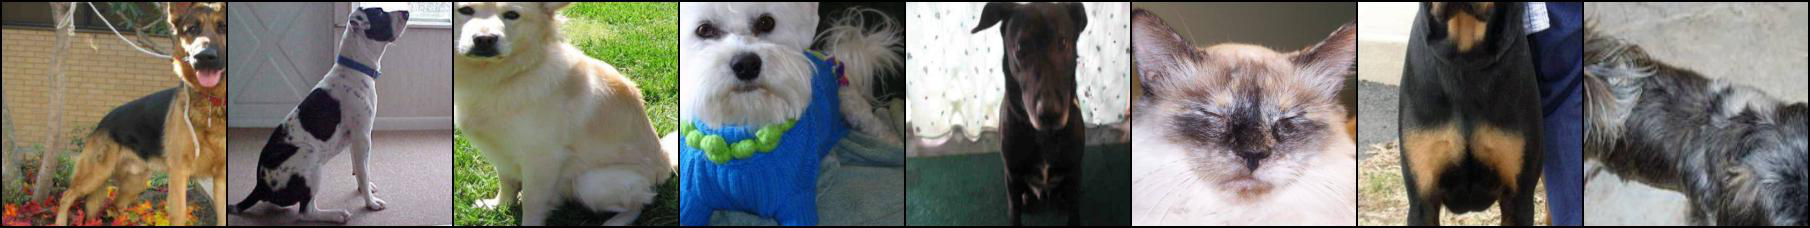

In [28]:
from PIL import Image
Image.open('test01.jpg')

### Pytorch的可视化工具-tensorboardX
使用时需要先安装tensorflow，然后安装tensorboardX
使用步骤
1. 导入tensorboardX，实例化SummaryWriter类
```python
from tensorboardX import SummaryWriter
writer = SummaryWriter(log_dir='logs') # 指定log路径
# 调用
writer.add_xxx()
# 关闭
writer.close()
```
SummaryWriter格式是`SummaryWriter(log_dir=None,comment='',**kwargs)`
2. 调用API接口，一般格式为`add_xxx(tag-name,object,iteration-number)` ，参数是标签，记录的对象，迭代次数
3. 启动tensorboard服务，需要在logs目录的同级目录，输入`tensorboaard --logdir=logs --port 6006`
4. 浏览器访问

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from tensorboardX import SummaryWriter

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,10,kernel_size=5)
        self.conv2 = nn.Conv2d(10,20,kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,10)
        self.bn = nn.BatchNorm2d(20)
        
    def forward(self,x):
        x = F.max_pool2d(self.conv1(x),2)
        x = F.relu(x) + F.relu(-x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x = self.bn(x)
        x = x.view(-1,320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x,training=self.training)
        x = self.fc2(x)
        x = F.softmax(x,dim=1)
        return x

In [35]:
# 定义输入
model_input = torch.rand(32,1,28,28)
model = Net()
with SummaryWriter(log_dir='logs',comment='Net') as w:
    w.add_graph(model, (model_input,))

In [33]:
!tensorboard --logdir=logs --port 6006

/bin/sh: tensorboard: command not found


In [40]:
import numpy as np
writer = SummaryWriter(log_dir='logs', comment='Linear')
np.random.seed(100)
x_train = np.linspace(-1,1,100).reshape(100,1)
y_train = 3*np.power(x_train,2) + 2 + 0.2*np.random.randn(x_train.size).reshape(100,1)

model = nn.Linear(1,1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
for epoch in range(5):
    inputs = torch.from_numpy(x_train).type(torch.float32)
    targets = torch.from_numpy(y_train).type(torch.float32)
    
    output = model(inputs)
    loss = criterion(output,targets)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    writer.add_scalar('LOSS',loss,epoch)